In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn import metrics
import xgboost as xgb

plt.rcParams['font.size'] = 12


In [14]:
#Import training and validation data
df = pd.read_csv('build/training_data.csv')
lbl = df['label']
df = df.drop(columns='label')

Xtrain,Xtest, ytrain, ytest = train_test_split(df, lbl, test_size = 0.3, random_state = 555)
df

,LineFit_TTParams.lf_vel_z,HitStatisticsValues.max_pulse_time,SplineMPEFitParams.rlogl,HitStatisticsValues.z_travel,SplineMPEDirectHitsA.n_dir_strings,LineFit_TT.zenith,NewAtt.DeltaZd,MuEXAngular4.zenith,NewAtt.SplineVerRadius,SplineMPEDirectHitsA.n_dir_doms,...,MPEFitParaboloid.zenith,SplineMPETruncatedEnergy_SPICEMie_AllBINS_MuEres.value,MPEFitParaboloidFitParams.zenith,SplineMPETruncatedEnergy_SPICEMie_AllDOMS_MuEres.value,SPEFit2Bayesian.z,SplineMPECharacteristics.track_hits_separation_length,SplineMPEDirectHitsC.n_dir_doms,LineFit_TTParams.lf_vel,HitStatisticsValues.z_min,MPEFitParaboloidFitParams.err1
0,-0.039006,11655.622070,9.527728,-9.285001,2.0,1.415660,0.116032,1.540624,557.975828,2.0,...,1.496584,0.467407,1.496584,0.473491,490.568388,236.862871,7.0,0.252438,410.829987,0.079770
1,0.226667,13405.332031,6.926486,203.052916,4.0,2.417911,0.010944,2.406913,212.642776,7.0,...,2.408838,0.210015,2.408838,0.348095,81.889663,820.047420,14.0,0.302475,-500.200012,0.007612
2,-0.026912,11397.479492,10.349272,-22.333333,2.0,1.483396,0.029480,1.479112,105.849128,2.0,...,1.506315,0.321896,1.506315,0.473491,267.575435,385.934605,5.0,0.308312,228.500000,0.048491
3,0.241593,12022.561523,9.704814,31.992822,1.0,2.746615,0.126354,2.649870,497.367486,1.0,...,2.644852,0.467407,2.644852,0.529430,136.474215,140.185080,6.0,0.261746,-74.430000,0.084265
4,-0.026998,12417.220703,8.578180,3.873225,1.0,1.457079,0.259349,1.650295,350.991180,1.0,...,1.690177,0.467407,1.690177,0.499311,-777.318232,155.787565,6.0,0.237930,-504.160004,0.099731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35647,-0.024430,13429.544922,7.933090,-26.410793,0.0,1.485914,0.019126,1.503940,212.895601,0.0,...,1.413994,0.210015,1.405324,0.284395,449.071620,515.619045,11.0,0.288154,329.920013,0.016972
35648,0.182234,10987.291016,10.045274,75.578124,0.0,2.083963,0.042569,2.122861,495.793099,0.0,...,2.079540,0.467407,2.079540,0.499311,265.966671,366.630353,5.0,0.371195,63.610001,0.039435
35649,0.084131,12578.885742,9.839656,2.636447,1.0,1.879381,0.064629,1.833254,389.190496,2.0,...,1.836225,0.467407,1.836225,0.499311,45.237736,190.870900,7.0,0.277012,-76.099998,0.062428
35650,0.119519,14220.983398,6.860587,33.747436,5.0,2.030040,0.028894,2.061914,46.469219,11.0,...,2.056447,0.282338,2.056447,0.201952,-287.797472,108.615066,30.0,0.269631,-486.529999,0.016349


In [15]:
#Implementing training function with stratifiesKFold
def trainModel(X,y,k = 5):
    skf = StratifiedKFold(n_splits=k, random_state=555, shuffle=True)
    model = []
    for _, (train_index, test_index) in zip(tqdm(range(k)), skf.split(X, y)):
        bdt = xgb.XGBClassifier(tree_method='hist', random_state=555, objective='binary:logistic'
                              , early_stopping_rounds=10, eval_metric=["logloss"])
        
        bdt.fit(X.to_numpy()[train_index], y.to_numpy()[train_index],
                eval_set=[(X.to_numpy()[test_index], y.to_numpy()[test_index])]);
        model.append(bdt)
    return model

model = trainModel(Xtrain,ytrain, 5)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

[0]	validation_0-logloss:0.49537
[1]	validation_0-logloss:0.38157
[2]	validation_0-logloss:0.30848
[3]	validation_0-logloss:0.25781
[4]	validation_0-logloss:0.22240
[5]	validation_0-logloss:0.19550
[6]	validation_0-logloss:0.17495
[7]	validation_0-logloss:0.15937
[8]	validation_0-logloss:0.14818
[9]	validation_0-logloss:0.13913
[10]	validation_0-logloss:0.13196
[11]	validation_0-logloss:0.12622
[12]	validation_0-logloss:0.12159
[13]	validation_0-logloss:0.11752
[14]	validation_0-logloss:0.11445
[15]	validation_0-logloss:0.11216
[16]	validation_0-logloss:0.10924
[17]	validation_0-logloss:0.10810
[18]	validation_0-logloss:0.10645
[19]	validation_0-logloss:0.10528
[20]	validation_0-logloss:0.10443
[21]	validation_0-logloss:0.10308
[22]	validation_0-logloss:0.10259
[23]	validation_0-logloss:0.10203
[24]	validation_0-logloss:0.10147
[25]	validation_0-logloss:0.10148
[26]	validation_0-logloss:0.10101
[27]	validation_0-logloss:0.10041
[28]	validation_0-logloss:0.09975
[29]	validation_0-loglos

 20%|█████████                                    | 1/5 [00:02<00:10,  2.71s/it]

[0]	validation_0-logloss:0.50325
[1]	validation_0-logloss:0.38989
[2]	validation_0-logloss:0.31651
[3]	validation_0-logloss:0.26676
[4]	validation_0-logloss:0.22892
[5]	validation_0-logloss:0.20400
[6]	validation_0-logloss:0.18541
[7]	validation_0-logloss:0.17060
[8]	validation_0-logloss:0.15938
[9]	validation_0-logloss:0.15007
[10]	validation_0-logloss:0.14508
[11]	validation_0-logloss:0.14099
[12]	validation_0-logloss:0.13500
[13]	validation_0-logloss:0.13089
[14]	validation_0-logloss:0.12737
[15]	validation_0-logloss:0.12530
[16]	validation_0-logloss:0.12359
[17]	validation_0-logloss:0.12143
[18]	validation_0-logloss:0.12066
[19]	validation_0-logloss:0.11972
[20]	validation_0-logloss:0.11943
[21]	validation_0-logloss:0.11841
[22]	validation_0-logloss:0.11780
[23]	validation_0-logloss:0.11762
[24]	validation_0-logloss:0.11756
[25]	validation_0-logloss:0.11664
[26]	validation_0-logloss:0.11628
[27]	validation_0-logloss:0.11577
[28]	validation_0-logloss:0.11556
[29]	validation_0-loglos

 40%|██████████████████                           | 2/5 [00:04<00:06,  2.29s/it]

[0]	validation_0-logloss:0.49855
[1]	validation_0-logloss:0.38672
[2]	validation_0-logloss:0.31385
[3]	validation_0-logloss:0.26350
[4]	validation_0-logloss:0.22692
[5]	validation_0-logloss:0.20174
[6]	validation_0-logloss:0.18047
[7]	validation_0-logloss:0.16587
[8]	validation_0-logloss:0.15530
[9]	validation_0-logloss:0.14703
[10]	validation_0-logloss:0.14037
[11]	validation_0-logloss:0.13334
[12]	validation_0-logloss:0.12912
[13]	validation_0-logloss:0.12584
[14]	validation_0-logloss:0.12362
[15]	validation_0-logloss:0.12075
[16]	validation_0-logloss:0.11934
[17]	validation_0-logloss:0.11745
[18]	validation_0-logloss:0.11624
[19]	validation_0-logloss:0.11444
[20]	validation_0-logloss:0.11309
[21]	validation_0-logloss:0.11124
[22]	validation_0-logloss:0.10979
[23]	validation_0-logloss:0.10910
[24]	validation_0-logloss:0.10800
[25]	validation_0-logloss:0.10785
[26]	validation_0-logloss:0.10758
[27]	validation_0-logloss:0.10668
[28]	validation_0-logloss:0.10492
[29]	validation_0-loglos

 60%|███████████████████████████                  | 3/5 [00:06<00:04,  2.08s/it]

[0]	validation_0-logloss:0.49804
[1]	validation_0-logloss:0.38563
[2]	validation_0-logloss:0.31353
[3]	validation_0-logloss:0.26174
[4]	validation_0-logloss:0.22609
[5]	validation_0-logloss:0.19961
[6]	validation_0-logloss:0.17988
[7]	validation_0-logloss:0.16389
[8]	validation_0-logloss:0.15238
[9]	validation_0-logloss:0.14421
[10]	validation_0-logloss:0.13643
[11]	validation_0-logloss:0.13088
[12]	validation_0-logloss:0.12595
[13]	validation_0-logloss:0.12285
[14]	validation_0-logloss:0.12122
[15]	validation_0-logloss:0.11807
[16]	validation_0-logloss:0.11582
[17]	validation_0-logloss:0.11248
[18]	validation_0-logloss:0.11167
[19]	validation_0-logloss:0.10902
[20]	validation_0-logloss:0.10756
[21]	validation_0-logloss:0.10662
[22]	validation_0-logloss:0.10553
[23]	validation_0-logloss:0.10466
[24]	validation_0-logloss:0.10385
[25]	validation_0-logloss:0.10348
[26]	validation_0-logloss:0.10315
[27]	validation_0-logloss:0.10263
[28]	validation_0-logloss:0.10260
[29]	validation_0-loglos

 80%|████████████████████████████████████         | 4/5 [00:07<00:01,  1.63s/it]

[0]	validation_0-logloss:0.49866
[1]	validation_0-logloss:0.38769
[2]	validation_0-logloss:0.31595
[3]	validation_0-logloss:0.26408
[4]	validation_0-logloss:0.22710
[5]	validation_0-logloss:0.19889
[6]	validation_0-logloss:0.17891
[7]	validation_0-logloss:0.16367
[8]	validation_0-logloss:0.15093
[9]	validation_0-logloss:0.14142
[10]	validation_0-logloss:0.13457
[11]	validation_0-logloss:0.12823
[12]	validation_0-logloss:0.12414
[13]	validation_0-logloss:0.12004
[14]	validation_0-logloss:0.11740
[15]	validation_0-logloss:0.11467
[16]	validation_0-logloss:0.11311
[17]	validation_0-logloss:0.11135
[18]	validation_0-logloss:0.11020
[19]	validation_0-logloss:0.10940
[20]	validation_0-logloss:0.10927
[21]	validation_0-logloss:0.10807
[22]	validation_0-logloss:0.10635
[23]	validation_0-logloss:0.10527
[24]	validation_0-logloss:0.10484
[25]	validation_0-logloss:0.10429
[26]	validation_0-logloss:0.10393
[27]	validation_0-logloss:0.10316
[28]	validation_0-logloss:0.10299
[29]	validation_0-loglos

100%|█████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


In [16]:
#Implementing prediction
def predict(model, X):
    res = []
    for m in model:
        res.append(m.predict_proba(X)[:,1])
    return np.mean(res, axis = 0)

ypred = predict(model, Xtest.to_numpy())
ypred

array([9.9863654e-01, 1.4577109e-03, 9.9847853e-01, ..., 1.6313247e-02,
       2.8487784e-04, 1.1216663e-03], dtype=float32)

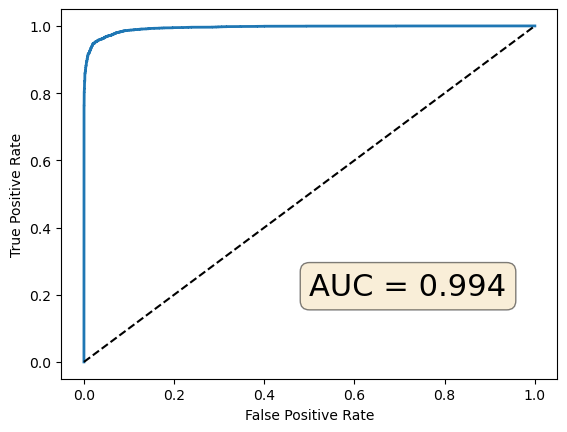

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, tresholds = roc_curve(ytest, ypred)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12


AUC = metrics.roc_auc_score(ytest, ypred)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.text(0.5, 0.2, f'AUC = {np.round(AUC, 3)}', fontsize = 22, bbox = props)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('build/BDTRoc.pdf')

In [18]:
#save ROC,AUC curve to disk
file = open('build/BdtRoc.txt', 'w')
file.write('#fpr tpr\n')
for f, t in zip(fpr, tpr):
    file.write(f'{f} {t}\n')
file.write(f'-1 {AUC}')
file.close()

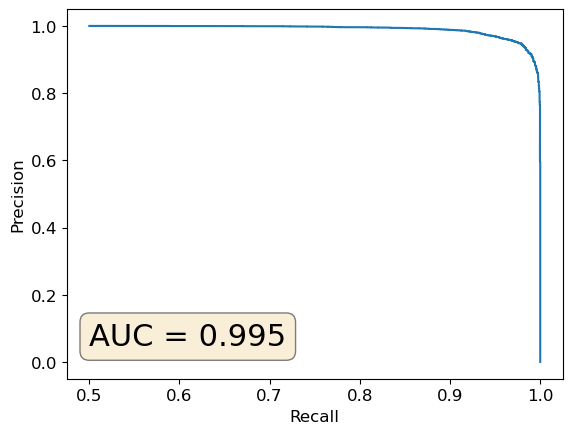

In [48]:
#Calc Precision Recall curve
prec, rec, thresh = metrics.precision_recall_curve(ytest, ypred)

prcauc = np.sum((rec[:-1]-rec[1:])*(prec[1:]+prec[:-1])/2)

plt.text(0.5, 0.05, f'AUC = {np.round(prcauc, 3)}', fontsize = 22, bbox = props)
plt.xlabel('Recall')
plt.ylabel('Precision')


plt.plot(prec, rec)


plt.savefig('build/BDTPRC.pdf')

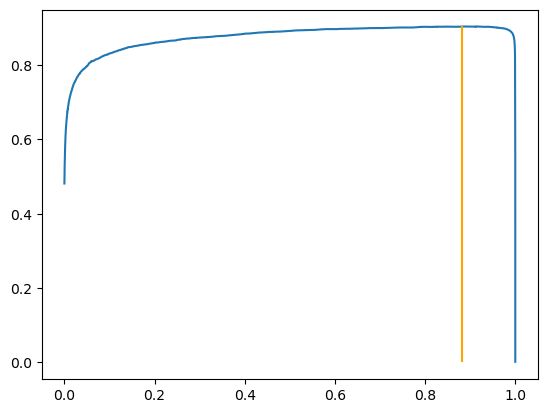

In [20]:
#Find Threshold with fbeta score
def fbeta(p, r, beta = 0.1):
    return (1+beta**2)*(p*r)/(beta*p+r)

fb = fbeta(prec, rec)[:-1]
argTr = np.argmax(fb)
plt.plot(thresh, fb)
plt.vlines(thresh[argTr], 0, fb[argTr], color = 'orange', label = 'peak')



plt.savefig('build/BDTFbeta.pdf')

In [21]:
#classify test data
dftest = pd.read_csv('test.csv', usecols = df.columns).reindex(columns = df.columns)


ypred_test = predict(model, dftest)

threshold = thresh[argTr]
ycls = ypred_test > threshold
ycls = [1 if i else 0 for i in ycls]

In [27]:
#save ROC,AUC and fbeta curve to disk
file = open('build/BDTPRC.txt', 'w')
file.write('#Precision Recal fb thresh\n')
for f, t,b, tr in zip(prec[:-1], rec[:-1], fb, thresh):
    file.write(f'{f} {t} {b} {tr}\n')
file.close()

In [25]:
#save predictions
file = open('build/BdtClassified.txt', 'w')
file.write('#label\n')
for f in ycls:
    file.write(f'{f}\n')
file.close()

In [44]:
ycls = ypred > threshold
ycls = np.array([1 if i else 0 for i in ycls])


yclsSig = ycls[ytest == 1]
yclsBkg = ycls[ytest == 0]



np.mean(yclsSig) , np.mean(yclsBkg), 1000 / (np.mean(yclsSig) / np.mean(yclsBkg))

(0.8928971962616823, 0.005424616535727646, 6.075297983283003)